# 0D model of low-Atwood, single-mode RTI

Lots of imports.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.html.widgets import interact

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import bisect
from scipy.special import erf
import json
from functools import partial
class Foo: pass
from chest import Chest
from slict import CachedSlict
from glopen import glopen, glopen_many
prefix = "cnv"

/home/maxhutch/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from globussh import ls
def load_from_archive(names, arch):
    cs = []
    to_remove = []
    for name in names:
        try:
            foo = ls(arch + "/" + "{:s}-results".format(name))
        except:
            to_remove.append(name)
            continue
        cs.append(Chest(path      = "{:s}-results".format(name),
                        open      = partial(glopen,      endpoint=arch),
                        open_many = partial(glopen_many, endpoint=arch)))
    for name in to_remove:
        names.remove(name)
    scs = [CachedSlict(c) for c in cs]

    ps = []
    for name in names:
        with glopen(
                    "{:s}.json".format(name), mode='r',
                    endpoint = arch,
                    ) as f:
            ps.append(json.load(f))
    if len(names) == 1:
        return cs[0], scs[0], ps[0]
    return cs, scs, ps

In [3]:
import pickle
from os.path import exists
if exists("{}_err.p".format(prefix)):
    with open("{}_err.p".format(prefix), "rb") as f:
        err_d = pickle.load(f)
else:
    err_d = {}
    err_d[0,0,'A'] = 1
err = CachedSlict(err_d)

We're going to compare/train on model on DNS data.  Here, we list which data sets to use and where they live.

In [4]:
config = Foo()
orders = [4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 32]
elms = [1, 2, 4, 8, 12, 16, 24, 32, 48, 64, 96, 128]
#elms = [4, 8, 12, 16, 20, 24, 28, 32]
config.names = []
for order in orders:
    for elm in elms:
        if (order, elm) in err[:,:,'A'].keys():
            continue
        if order * elm >= 32 and order * elm <= 512:
            config.names.append("{:s}_o{:d}_e{:d}/{:s}_o{:d}_e{:d}".format(prefix, order, elm, prefix, order, elm))
#config.names.remove("cnv_o4_e24/cnv_o4_e24")
#config.names.remove("cnv_o6_e24/cnv_o6_e24")
#config.names.remove("cnv_o12_e12/cnv_o12_e12")
#config.names     = [
#    "Conv/cnv_o8_e32/cnv_o8_e32",
#    "Conv/cnv_o4_e64/cnv_o4_e64",
#    "Conv/cnv_o16_e8/cnv_o16_e8",
#    "Conv/cnv_o16_e4/cnv_o16_e4",
#    "Conv/cnv_o8_e16/cnv_o8_e16",
#    "Conv/cnv_o8_e8/cnv_o8_e8",
#    "Conv/cnv_o8_e4/cnv_o8_e4", 
#    "Conv/cnv_o6_e4/cnv_o6_e4",
#    "Conv/cnv_o4_e32/cnv_o4_e32",
#    "Conv/cnv_o4_e16/cnv_o4_e16",
#    "Conv/cnv_o4_e8/cnv_o4_e8",    
#    "Conv/cnv_o4_e4/cnv_o4_e4",    
#    ]
config.ref = ["cnv_o16_e32/cnv_o16_e32",]
if config.ref[0] in config.names:
    config.names.remove(config.ref[0])
#config.ref = ["cnv_long_o16_e16/cnv_long_o16_e16",]
#config.arch_end = "maxhutch#alpha-admin/~/pub/"
config.arch_end = "alcf#dtn_mira/projects/HighAspectRTI/experiments/ConvergeRTI"
#config.arch_end = "alcf#dtn_mira/projects/alpha-nek/experiments/ConvergeRTI"

This opens the data.  Could be rolled into a utility routine.

In [5]:
cs, scs, ps = load_from_archive(config.names, config.arch_end);
rc, rsc, rp = load_from_archive(config.ref, config.arch_end);

The data is remote, so we pre-fetch it for efficiency.

In [6]:
#from interfaces.abstract import AbstractSlice
height = 'H_exp'
#mix = 't_abs_proj_z'
mix = 'Xi'
for c,sc in zip(cs, scs):
    c.prefetch(
          sc[:,height].full_keys()
        + sc[:,mix].full_keys()
    )
rc.prefetch(
          rsc[:,height].full_keys()
        + rsc[:,mix].full_keys()
           )
T_end = rsc[:,height].keys()[-1]

For each run in the data set, interpolate the heights with a spline, take a derivative, and compute the mixedness from the `t_abs_proj_z` field.

In [7]:
for sc, p in zip(scs, ps):
    dh = 0.
    da = 0.
    count = 0
    #print(sc[:,height].keys())
    for T in rsc[:,height].keys():
        if T in sc[:,height].keys():
            dh += (sc[T,height] - rsc[T,height])**2
            da += (sc[T,mix] - rsc[T,mix])**2
            count += 1
#        else:
#            print("Missing T={:} in order={:} Courant={}".format(T, p["order"], p["courant"]))
    if count < 33:
        print("{:},{:} not done, only {:} points".format(p['order'], p['shape_mesh'][0], count))
        continue
    err_d[p['order'], p['shape_mesh'][0], 'H'] = np.sqrt(dh/count)
    err_d[p['order'], p['shape_mesh'][0], 'A'] = np.sqrt(da/count)    
    #print("Done 1")    

8,48 not done, only 5 points
8,64 not done, only 5 points
10,32 not done, only 5 points
12,32 not done, only 9 points
14,24 not done, only 25 points
24,16 not done, only 17 points


In [8]:
import pickle
if (0,0,'A') in err_d:
    del err_d[0,0,'A']
if (16,32,'A') in err_d:
    del err_d[16,32,'A']
if (16,32,'H') in err_d:
    del err_d[16,32,'H']
with open("{}_err.p".format(prefix), "wb") as f:
    pickle.dump(err_d, f)

In [9]:
import pickle
with open("{}_times_shaheen.p".format(prefix), "rb") as f:
    times_shaheen = CachedSlict(pickle.load(f))
with open("{}_times_mira.p".format(prefix), "rb") as f:
    times_mira = CachedSlict(pickle.load(f))

In [10]:
def my_scatter(xs, ys, labels):
    ax = plt.gca()
    ax.scatter(xs, ys)
    ax.set_xscale('log')
    ax.set_yscale('log')
    for x, y, label in zip(xs, ys, labels):
        ax.annotate(label, xy=(x, y), xytext = (20, 10), textcoords = 'offset points', ha = 'right', va = 'bottom')
    plt.ylim(10**int(np.log10(np.min(ys))-1), 10**int(np.log10(np.max(ys))))

def err_vs(time, name):
    err = CachedSlict(err_d)
    plt.figure(figsize=(12,12))
    core_hr = np.array([time[k[0],k[1]] for k in time[:,:].keys() if k in err[:,:,'H'].keys()])/3600
    log_err = np.array([err[k[0], k[1], 'H'] for k in err[:,:,'H'].keys() if k in time[:,:].keys()])
    labels = ["{:d}, {:d}".format(k[0], k[1]) for k in time[:,:].keys() if k in err[:,:,'H'].keys()]
    my_scatter(core_hr, log_err, labels)
    plt.savefig('{}_H.pdf'.format(name))
    plt.figure(figsize=(12,12))
    log_err = np.array([err[k[0], k[1], 'A'] for k in err[:,:,'A'].keys() if k in time[:,:].keys()])
    my_scatter(core_hr, log_err, labels)
    plt.savefig('{}_A.pdf'.format(name))    

In [21]:
def my_scatter(xs, ys, labels):
    ax = plt.gca()
    ax.scatter(xs, ys)
    ax.set_xscale('log')
    ax.set_yscale('log')
    for x, y, label in zip(xs, ys, labels):
        ax.annotate(label, xy=(x, y), xytext = (20, 10), textcoords = 'offset points', ha = 'right', va = 'bottom')
    plt.ylim(10**int(np.log10(np.min(ys))-1), 10**int(np.log10(np.max(ys))))

def err_vs2(time_in, name):
    err_d_filt = {(k[0], k[1]):err_d[k[0],k[1],'H'] for k in err_d.keys() if (k[0],k[1]) in time_in.keys()}
    del err_d_filt[32,8]
    time_filt = {k:time_in[k]/3600 for k in err_d_filt.keys()}
    err = CachedSlict(err_d_filt)
    time = CachedSlict(time_filt)
    plt.figure(figsize=(12,12))
    ax = plt.gca()
    
    core_hr = np.array(time.values())
    log_err = np.array(err.values())
    labels = ["{:d}, {:d}".format(k[0], k[1]) for k in time.keys()]

    for x, y, label in zip(core_hr, log_err, labels):
        ax.annotate(label, xy=(x, y), xytext = (20, 10), textcoords = 'offset points', ha = 'right', va = 'bottom')
    
    ax.scatter(core_hr, log_err)
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.ylim(10**int(np.log10(np.min(err.values()))-1),
             10**int(np.log10(np.max(err.values()))))
    

    for order, elm in time[:,:].keys():
        if (order*2,elm) in time[:,:].keys():
            xs = [time[order,elm], time[order*2,elm]]
            ys = [err[order,elm],  err[order*2,elm]]
            ax.plot(xs, ys, 'b--')
        if (order,elm*2) in time[:,:].keys():
            xs = [time[order,elm], time[order,elm*2]]
            ys = [err[order,elm],  err[order,elm*2]]
            ax.plot(xs, ys, 'r--')

    
    
    plt.figure()
    ax = plt.gca()
    
    for order, elm in time[:,:].keys():
        if (order*2,elm) in time[:,:].keys():
            xs = [1, time[order*2,elm]/time[order,elm]]
            ys = [1,  err[order*2,elm]/err[order,elm]]
            ax.plot(xs, ys, 'b--')
        if (order,elm*2) in time[:,:].keys():
            xs = [1, time[order,elm*2]/time[order,elm]]
            ys = [1,  err[order,elm*2]/err[order,elm]]
            ax.plot(xs, ys, 'r--')
    ax.set_xscale('log')
    ax.set_yscale('log')



    #plt.savefig('{}_H.pdf'.format(name)) 

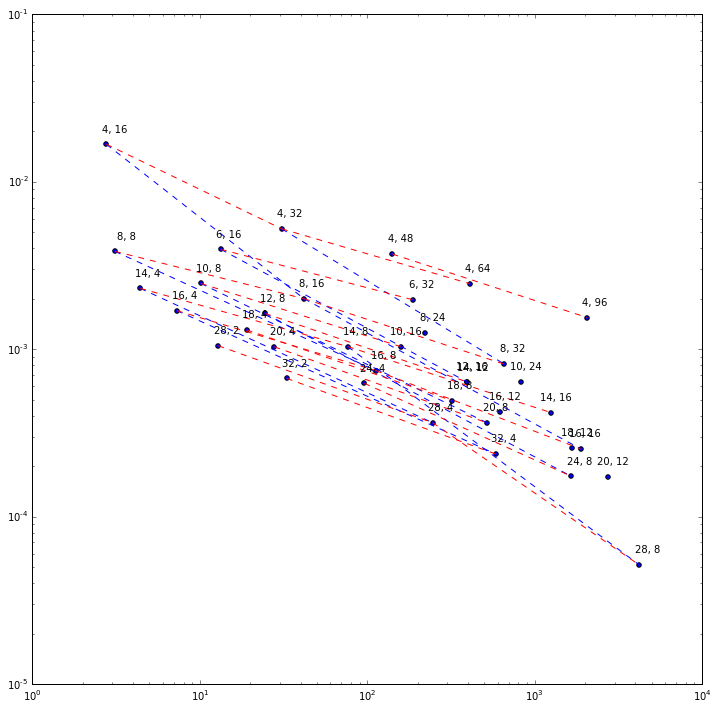

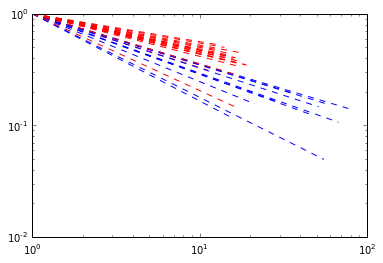

In [22]:
err_vs2(times_mira[:,:,'time'], 'mira')

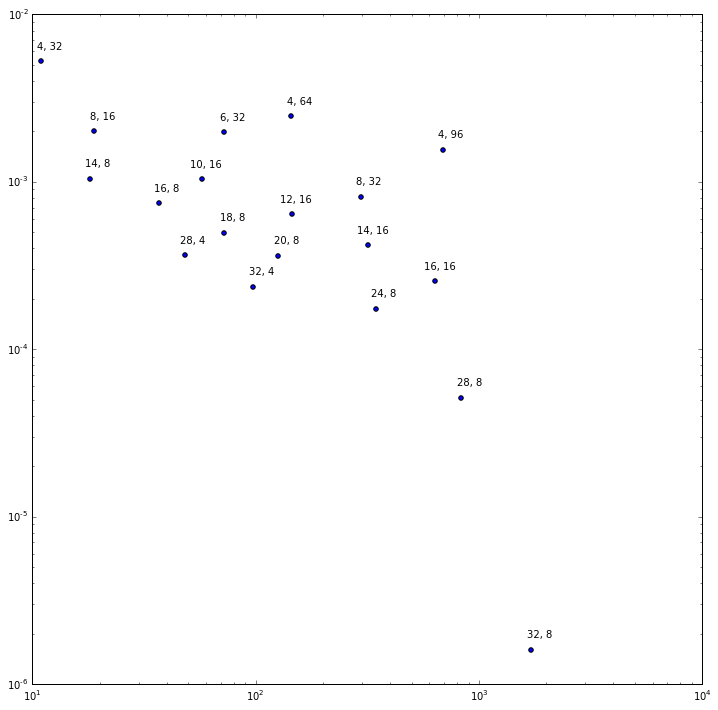

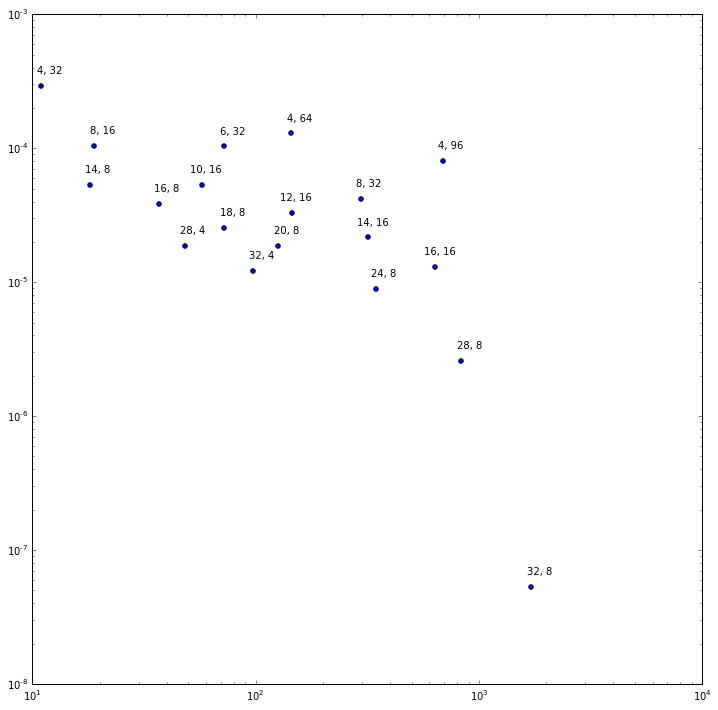

In [13]:
err_vs(times_shaheen[:,:,'time'], 'shaheen')

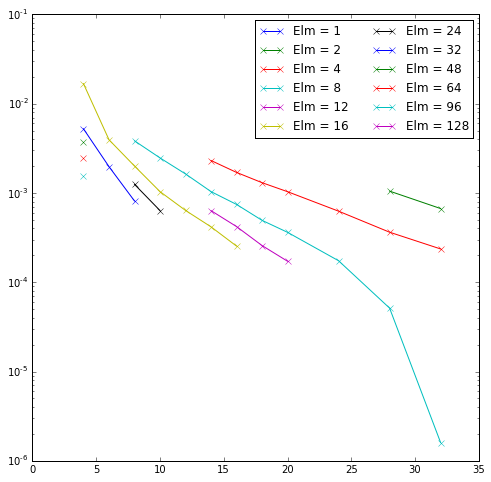

In [14]:
err = CachedSlict(err_d)
plt.figure(figsize=(8,8))
for elm in elms:
    plt.semilogy(err[:,elm,'H'].keys(), err[:,elm,'H'].values(), 'x-', label="Elm = {:d}".format(elm))
plt.legend(ncol=2)